Método de Covarianza Reducida --- 6:09 min
===

* 6:09 min | Última modificación: Septiembre 23, 2021 | [YouTube](https://youtu.be/x223K0ex1xk)

La covarianza empírica de una muestra de datos puede ser computada usando el método de máxima verosimilitud (EmpiricalCovariance), cuando hay un número suficiente de datos; sin embargo, la estimación es sensible a la presencia de outliers, y a otros muchos aspectos de los datos.

Una estimación inapropiada (poco precisa) de la matriz de covarianzas causa que la matriz de precisión (la inversa de la matriz de covarianzas) no pueda ser estimada. Dicha matriz de precisión es una alternativa al uso de la matriz de covarianzas y se suele utilizar en muchas metodologías.

Los métodos de covarianza reducida son una aproximación que mejora la aproximación de los valores propios de la matriz de covarianzas, logrando que su inversión sea más precisa, esto es, la computación de la matriz de precisión.

La transformación aplicada es la siguiente:

$$
\Sigma_{\text{shrunk}} = (1 - \alpha) \hat{\Sigma} + \alpha \frac{\text{Tr} \hat{\Sigma}}{p} \mathbf{\text{Id}}
$$

Ledoit & Wolf proponen un método para computar el valor óptimo de $\alpha$ que minimiza el error cuadrático medio entre la matriz de covarianza real y la estimada.

Chen et al proponen una formula alternativa que mejora el resultado de Ledoit & Wolf. Esta es conocida como Oracle Shrinkage Approximating estimaator.

https://scikit-learn.org/stable/auto_examples/covariance/plot_covariance_estimation.html

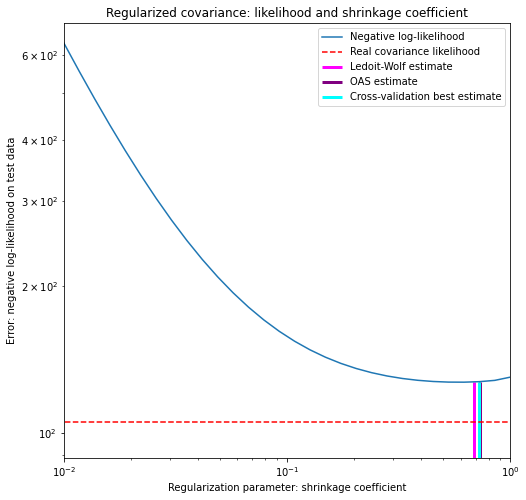

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn.covariance import (
    OAS,
    LedoitWolf,
    ShrunkCovariance,
    empirical_covariance,
    log_likelihood,
)
from sklearn.model_selection import GridSearchCV

#
# Tamaño de las muestras
#
n_features, n_samples = 40, 20

#
# Generación de las muestras
#
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

#
# Cálculo de la covarianza real de los datos
#
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

#
# Covarianza computada para la muestra de prueba usando
# diferentes valores del coeficiente de regularización
#
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [
    -ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test) for s in shrinkages
]

#
# Búsqueda del mejor coeficiente de regularización usando
# validación cruzada
#
tuned_parameters = [{"shrinkage": shrinkages}]
cv = GridSearchCV(
    ShrunkCovariance(),
    tuned_parameters,
)
cv.fit(X_train)
loglik_cv = cv.best_estimator_.score(X_test)


#
# Mejor coeficiente de regularización usando
# Oracle Approximating Shrinkage
#
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

#
# Mejor coeficiente de regularización usando el método
# de Ledoit-Wolf
#
oas = OAS()
loglik_oas = oas.fit(X_train).score(X_test)


fig = plt.figure(figsize=(8, 8))

plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel("Regularization parameter: shrinkage coefficient")
plt.ylabel("Error: negative log-likelihood on test data")


plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], "--r", label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10.0 * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]

plt.vlines(
    lw.shrinkage_,
    ymin,
    -loglik_lw,
    color="magenta",
    linewidth=3,
    label="Ledoit-Wolf estimate",
)

plt.vlines(
    oas.shrinkage_, ymin, -loglik_oas, color="purple", linewidth=3, label="OAS estimate"
)

plt.vlines(
    cv.best_estimator_.shrinkage,
    ymin,
    -loglik_cv,
    color="cyan",
    linewidth=3,
    label="Cross-validation best estimate",
)

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()